# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [1]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "cmnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)
len(unlearned_data)

138

In [2]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [3]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883) 7
- 1025 (train: 880,  test: 145) 7e

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [4]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [5]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [6]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [7]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [8]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [10]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

36.35766925464074

In [11]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

36.356093346575896

#### Trained to ...

In [12]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

38.120168990890186

In [13]:
calc_mutlimodel_metric_average(modeltype1=trained_ms, modeltype2=trained_ms, metric="l2_norm")

0.0

#### Exact to ...

In [14]:
# see above

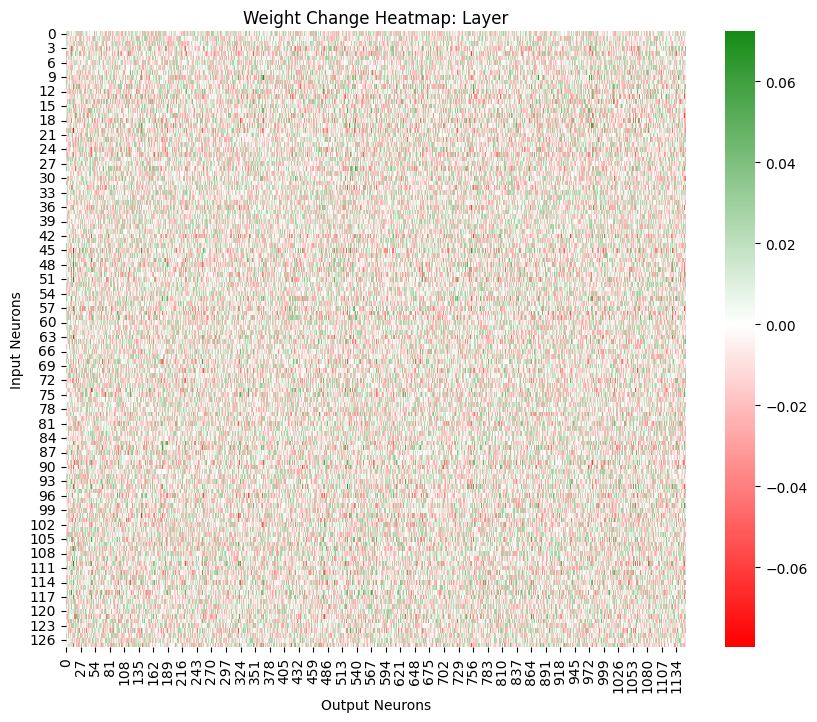

In [15]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[0].fc1.weight, weights_after=torch.zeros_like(exact_ms[0].fc1.weight))

### Layer-wise Comparison

In [16]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), exact_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'conv1.weight': 118.11303787231445,
 'conv1.bias': 3.987702186902364,
 'conv2.weight': 852.6168436686198,
 'conv2.bias': 2.7653661171595254,
 'conv3.weight': 2287.059318033854,
 'conv3.bias': 3.7651674429575603,
 'fc1.weight': 3132.43447265625,
 'fc1.bias': 2.5489752769470213,
 'fc2.weight': 83.20081125895182,
 'fc2.bias': 0.5889566411574682}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [17]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [18]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.5709445387125014

In [19]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.4086827305731946

#### Trained to...

In [20]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

4.010024175379011

In [21]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.3941369535746397

#### Exact to...

In [22]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

3.4655104142648208

In [23]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.4127132133477263

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [24]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.1026 - Standard Deviation for D_gesamt: 0.0141


Average Accuracy for D_remain: 0.1013 - Standard Deviation for D_remain: 0.0137


Average Accuracy for 0: 0.0994 - Standard Deviation for 0: 0.2789


Average Accuracy for 1: 0.1608 - Standard Deviation for 1: 0.3243


Average Accuracy for 2: 0.1977 - Standard Deviation for 2: 0.3895


Average Accuracy for 3: 0.1198 - Standard Deviation for 3: 0.3069


Average Accuracy for 4: 0.0958 - Standard Deviation for 4: 0.2618


Average Accuracy for 5: 0.0327 - Standard Deviation for 5: 0.0964


Average Accuracy for 6: 0.0336 - Standard Deviation for 6: 0.1788


Average Accuracy for 8: 0.0401 - Standard Deviation for 8: 0.1319


Average Accuracy for 9: 0.0328 - Standard Deviation for 9: 0.1766


Average Accuracy for 7_all: 0.1891 - Standard Deviation for 7_all: 0.3485


Average Accuracy for 7_remain: 0.1883 - Standard Deviation for 7_remain: 0.3489


Average Accuracy for 7_erased: 0.1947 - Standard Deviation for 7_erased: 0.3487
plotting...


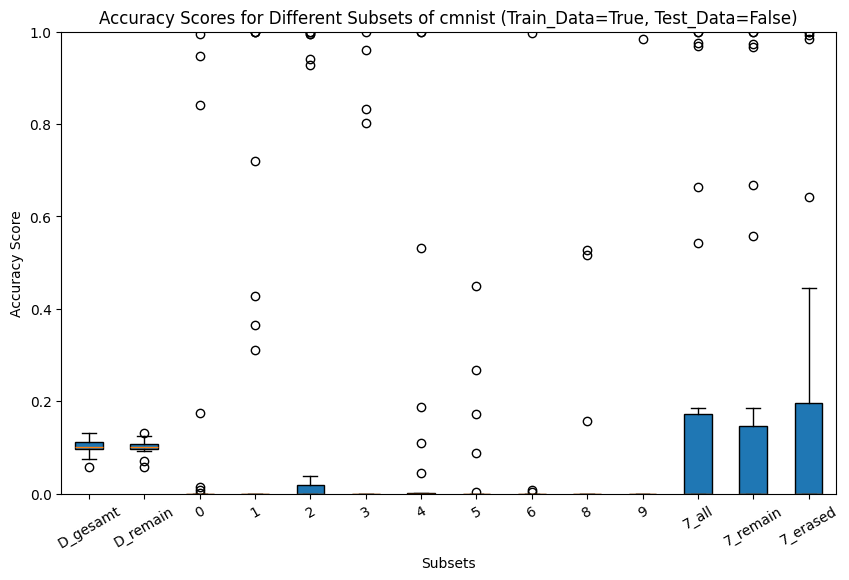

In [25]:
accs["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.1026 - Standard Deviation for D_gesamt: 0.0142


Average Accuracy for D_remain: 0.1014 - Standard Deviation for D_remain: 0.0145


Average Accuracy for 0: 0.0997 - Standard Deviation for 0: 0.2812


Average Accuracy for 1: 0.1617 - Standard Deviation for 1: 0.3268


Average Accuracy for 2: 0.1982 - Standard Deviation for 2: 0.3888


Average Accuracy for 3: 0.1211 - Standard Deviation for 3: 0.3100


Average Accuracy for 4: 0.0955 - Standard Deviation for 4: 0.2627


Average Accuracy for 5: 0.0318 - Standard Deviation for 5: 0.0936


Average Accuracy for 6: 0.0336 - Standard Deviation for 6: 0.1777


Average Accuracy for 8: 0.0382 - Standard Deviation for 8: 0.1271


Average Accuracy for 9: 0.0328 - Standard Deviation for 9: 0.1765


Average Accuracy for 7_all: 0.1883 - Standard Deviation for 7_all: 0.3491


Average Accuracy for 7_remain: 0.1878 - Standard Deviation for 7_remain: 0.3496


Average Accuracy for 7_erased: 0.1915 - Standard Deviation for 7_erased: 0.3475
plotting...


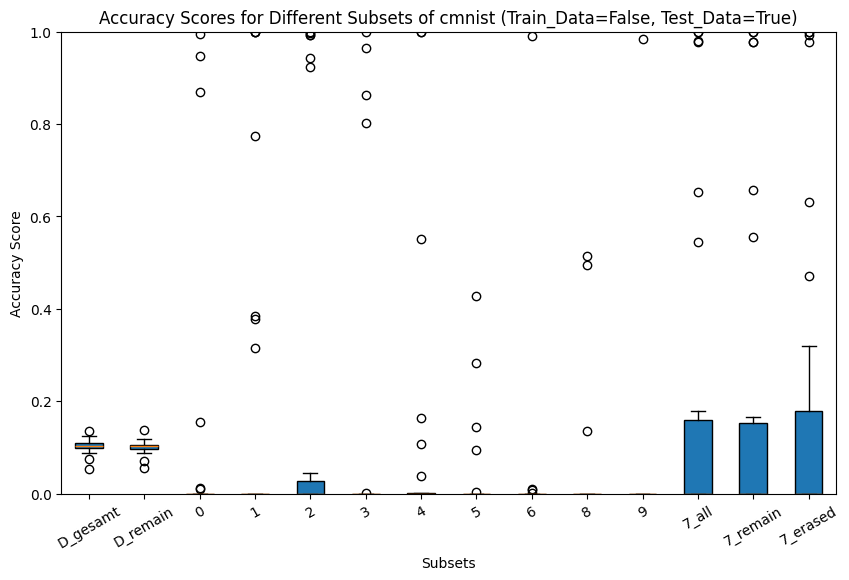

In [26]:
accs["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.9224 - Standard Deviation for D_gesamt: 0.0055


Average Accuracy for D_remain: 0.9252 - Standard Deviation for D_remain: 0.0053


Average Accuracy for 0: 0.9674 - Standard Deviation for 0: 0.0065


Average Accuracy for 1: 0.9596 - Standard Deviation for 1: 0.0060


Average Accuracy for 2: 0.9165 - Standard Deviation for 2: 0.0119


Average Accuracy for 3: 0.8872 - Standard Deviation for 3: 0.0250


Average Accuracy for 4: 0.9291 - Standard Deviation for 4: 0.0157


Average Accuracy for 5: 0.9151 - Standard Deviation for 5: 0.0148


Average Accuracy for 6: 0.9525 - Standard Deviation for 6: 0.0090


Average Accuracy for 8: 0.8953 - Standard Deviation for 8: 0.0187


Average Accuracy for 9: 0.9005 - Standard Deviation for 9: 0.0140


Average Accuracy for 7_all: 0.8962 - Standard Deviation for 7_all: 0.0219


Average Accuracy for 7_remain: 0.9224 - Standard Deviation for 7_remain: 0.0187


Average Accuracy for 7_erased: 0.7251 - Standard Deviation for 7_erased: 0.0515
plotting...


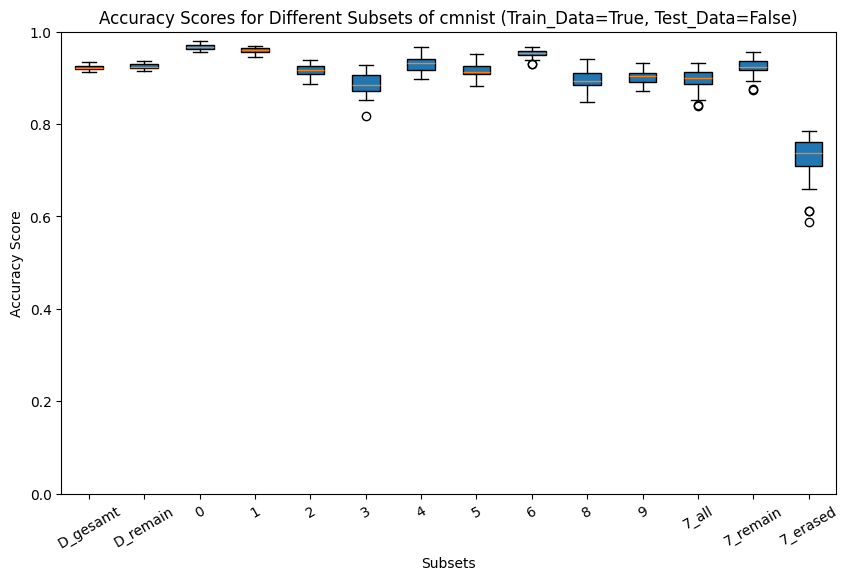

In [27]:
accs["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.9205 - Standard Deviation for D_gesamt: 0.0050


Average Accuracy for D_remain: 0.9250 - Standard Deviation for D_remain: 0.0048


Average Accuracy for 0: 0.9751 - Standard Deviation for 0: 0.0054


Average Accuracy for 1: 0.9687 - Standard Deviation for 1: 0.0060


Average Accuracy for 2: 0.9088 - Standard Deviation for 2: 0.0139


Average Accuracy for 3: 0.9048 - Standard Deviation for 3: 0.0227


Average Accuracy for 4: 0.9087 - Standard Deviation for 4: 0.0195


Average Accuracy for 5: 0.9018 - Standard Deviation for 5: 0.0155


Average Accuracy for 6: 0.9493 - Standard Deviation for 6: 0.0102


Average Accuracy for 8: 0.8857 - Standard Deviation for 8: 0.0169


Average Accuracy for 9: 0.9130 - Standard Deviation for 9: 0.0141


Average Accuracy for 7_all: 0.8837 - Standard Deviation for 7_all: 0.0177


Average Accuracy for 7_remain: 0.9270 - Standard Deviation for 7_remain: 0.0149


Average Accuracy for 7_erased: 0.6043 - Standard Deviation for 7_erased: 0.0443
plotting...


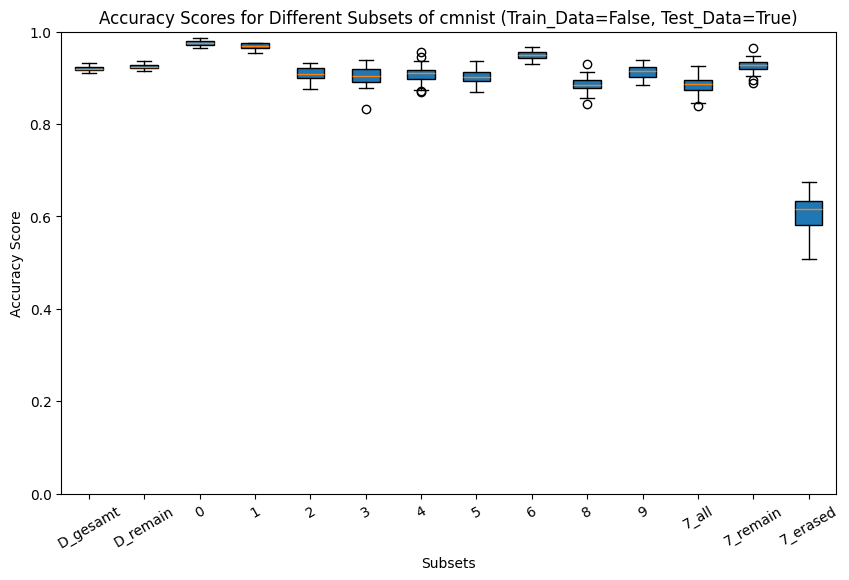

In [28]:
accs["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.9184 - Standard Deviation for D_gesamt: 0.0062


Average Accuracy for D_remain: 0.9264 - Standard Deviation for D_remain: 0.0059


Average Accuracy for 0: 0.9654 - Standard Deviation for 0: 0.0065


Average Accuracy for 1: 0.9607 - Standard Deviation for 1: 0.0062


Average Accuracy for 2: 0.9195 - Standard Deviation for 2: 0.0150


Average Accuracy for 3: 0.8898 - Standard Deviation for 3: 0.0185


Average Accuracy for 4: 0.9250 - Standard Deviation for 4: 0.0143


Average Accuracy for 5: 0.9170 - Standard Deviation for 5: 0.0159


Average Accuracy for 6: 0.9479 - Standard Deviation for 6: 0.0120


Average Accuracy for 8: 0.8970 - Standard Deviation for 8: 0.0202


Average Accuracy for 9: 0.9024 - Standard Deviation for 9: 0.0196


Average Accuracy for 7_all: 0.8585 - Standard Deviation for 7_all: 0.0195


Average Accuracy for 7_remain: 0.9331 - Standard Deviation for 7_remain: 0.0156


Average Accuracy for 7_erased: 0.3717 - Standard Deviation for 7_erased: 0.0587
plotting...


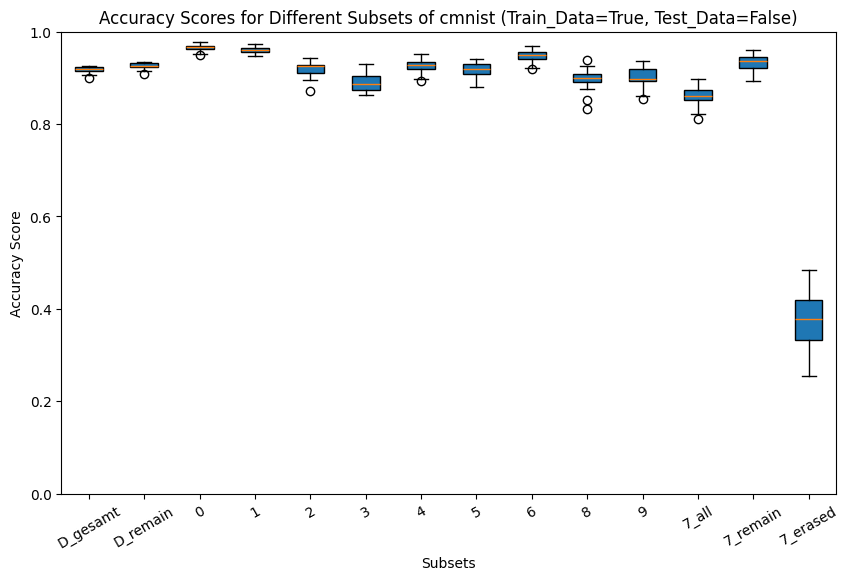

In [29]:
accs["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.9176 - Standard Deviation for D_gesamt: 0.0061


Average Accuracy for D_remain: 0.9254 - Standard Deviation for D_remain: 0.0060


Average Accuracy for 0: 0.9753 - Standard Deviation for 0: 0.0049


Average Accuracy for 1: 0.9708 - Standard Deviation for 1: 0.0054


Average Accuracy for 2: 0.9125 - Standard Deviation for 2: 0.0152


Average Accuracy for 3: 0.9042 - Standard Deviation for 3: 0.0160


Average Accuracy for 4: 0.9031 - Standard Deviation for 4: 0.0168


Average Accuracy for 5: 0.9040 - Standard Deviation for 5: 0.0189


Average Accuracy for 6: 0.9440 - Standard Deviation for 6: 0.0142


Average Accuracy for 8: 0.8892 - Standard Deviation for 8: 0.0182


Average Accuracy for 9: 0.9131 - Standard Deviation for 9: 0.0165


Average Accuracy for 7_all: 0.8540 - Standard Deviation for 7_all: 0.0158


Average Accuracy for 7_remain: 0.9315 - Standard Deviation for 7_remain: 0.0134


Average Accuracy for 7_erased: 0.3546 - Standard Deviation for 7_erased: 0.0429
plotting...


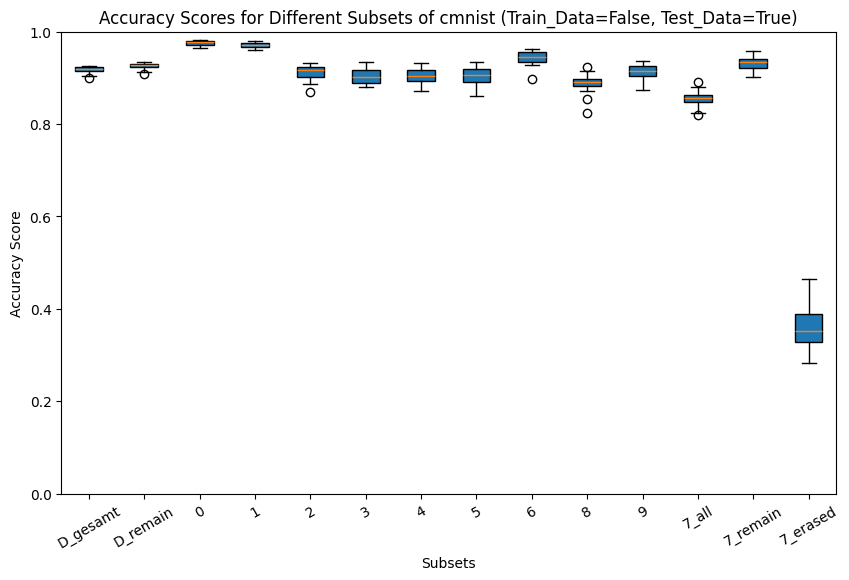

In [30]:
accs["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [31]:
losses = {}

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.2881 - Standard Deviation for D_gesamt: 0.0001


Average Loss for D_remain: 0.2881 - Standard Deviation for D_remain: 0.0001


Average Loss for 0: 0.2890 - Standard Deviation for 0: 0.0067


Average Loss for 1: 0.2877 - Standard Deviation for 1: 0.0064


Average Loss for 2: 0.2866 - Standard Deviation for 2: 0.0055


Average Loss for 3: 0.2904 - Standard Deviation for 3: 0.0075


Average Loss for 4: 0.2895 - Standard Deviation for 4: 0.0076


Average Loss for 5: 0.2909 - Standard Deviation for 5: 0.0060


Average Loss for 6: 0.2908 - Standard Deviation for 6: 0.0065


Average Loss for 8: 0.2899 - Standard Deviation for 8: 0.0052


Average Loss for 9: 0.2907 - Standard Deviation for 9: 0.0064


Average Loss for 7_all: 0.2867 - Standard Deviation for 7_all: 0.0069


Average Loss for 7_remain: 0.2862 - Standard Deviation for 7_remain: 0.0069


Average Loss for 7_erased: 0.2900 - Standard Deviation for 7_erased: 0.0071
plotting...


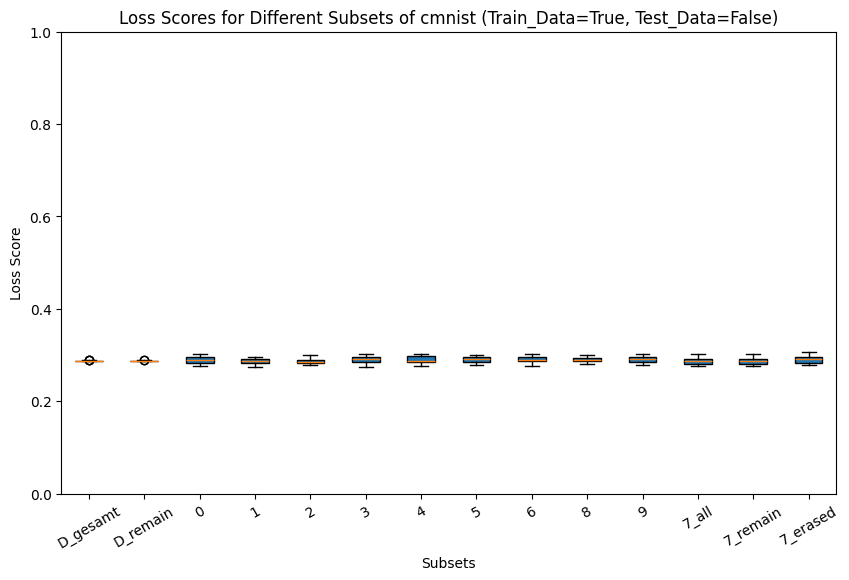

In [32]:
losses["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.2880 - Standard Deviation for D_gesamt: 0.0001


Average Loss for D_remain: 0.2881 - Standard Deviation for D_remain: 0.0002


Average Loss for 0: 0.2889 - Standard Deviation for 0: 0.0067


Average Loss for 1: 0.2879 - Standard Deviation for 1: 0.0065


Average Loss for 2: 0.2846 - Standard Deviation for 2: 0.0054


Average Loss for 3: 0.2912 - Standard Deviation for 3: 0.0075


Average Loss for 4: 0.2885 - Standard Deviation for 4: 0.0076


Average Loss for 5: 0.2907 - Standard Deviation for 5: 0.0060


Average Loss for 6: 0.2904 - Standard Deviation for 6: 0.0065


Average Loss for 8: 0.2888 - Standard Deviation for 8: 0.0052


Average Loss for 9: 0.2917 - Standard Deviation for 9: 0.0064


Average Loss for 7_all: 0.2866 - Standard Deviation for 7_all: 0.0069


Average Loss for 7_remain: 0.2874 - Standard Deviation for 7_remain: 0.0069


Average Loss for 7_erased: 0.2979 - Standard Deviation for 7_erased: 0.0073
plotting...


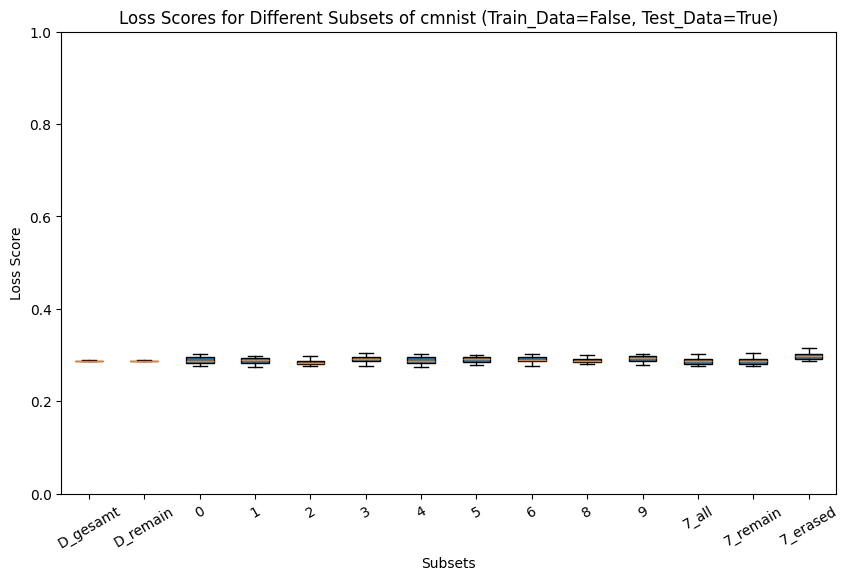

In [33]:
losses["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0329 - Standard Deviation for D_gesamt: 0.0019


Average Loss for D_remain: 0.0318 - Standard Deviation for D_remain: 0.0018


Average Loss for 0: 0.0160 - Standard Deviation for 0: 0.0030


Average Loss for 1: 0.0233 - Standard Deviation for 1: 0.0030


Average Loss for 2: 0.0360 - Standard Deviation for 2: 0.0055


Average Loss for 3: 0.0435 - Standard Deviation for 3: 0.0085


Average Loss for 4: 0.0280 - Standard Deviation for 4: 0.0045


Average Loss for 5: 0.0333 - Standard Deviation for 5: 0.0049


Average Loss for 6: 0.0188 - Standard Deviation for 6: 0.0030


Average Loss for 8: 0.0448 - Standard Deviation for 8: 0.0062


Average Loss for 9: 0.0509 - Standard Deviation for 9: 0.0061


Average Loss for 7_all: 0.0369 - Standard Deviation for 7_all: 0.0063


Average Loss for 7_remain: 0.0260 - Standard Deviation for 7_remain: 0.0050


Average Loss for 7_erased: 0.1115 - Standard Deviation for 7_erased: 0.0170
plotting...


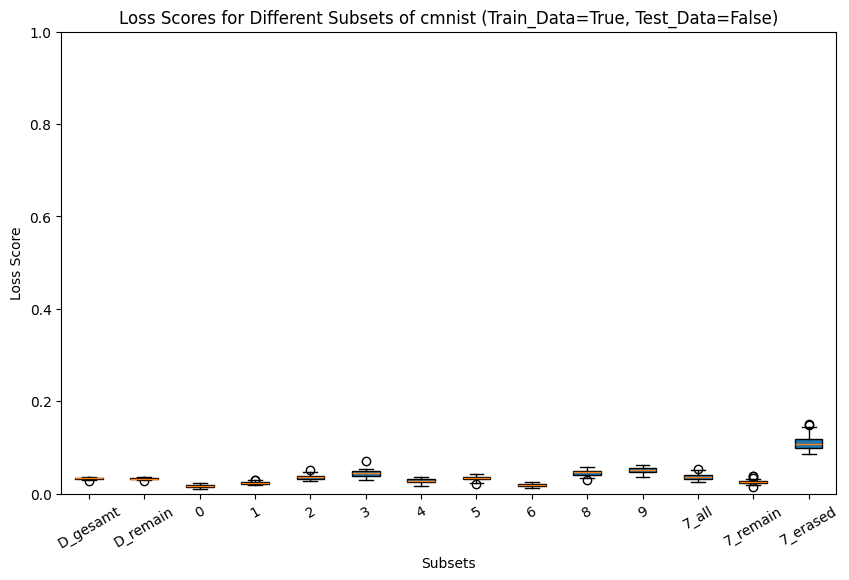

In [34]:
losses["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0336 - Standard Deviation for D_gesamt: 0.0019


Average Loss for D_remain: 0.0318 - Standard Deviation for D_remain: 0.0018


Average Loss for 0: 0.0130 - Standard Deviation for 0: 0.0026


Average Loss for 1: 0.0171 - Standard Deviation for 1: 0.0028


Average Loss for 2: 0.0363 - Standard Deviation for 2: 0.0055


Average Loss for 3: 0.0368 - Standard Deviation for 3: 0.0076


Average Loss for 4: 0.0341 - Standard Deviation for 4: 0.0052


Average Loss for 5: 0.0367 - Standard Deviation for 5: 0.0051


Average Loss for 6: 0.0224 - Standard Deviation for 6: 0.0037


Average Loss for 8: 0.0490 - Standard Deviation for 8: 0.0064


Average Loss for 9: 0.0499 - Standard Deviation for 9: 0.0059


Average Loss for 7_all: 0.0427 - Standard Deviation for 7_all: 0.0065


Average Loss for 7_remain: 0.0244 - Standard Deviation for 7_remain: 0.0047


Average Loss for 7_erased: 0.1744 - Standard Deviation for 7_erased: 0.0223
plotting...


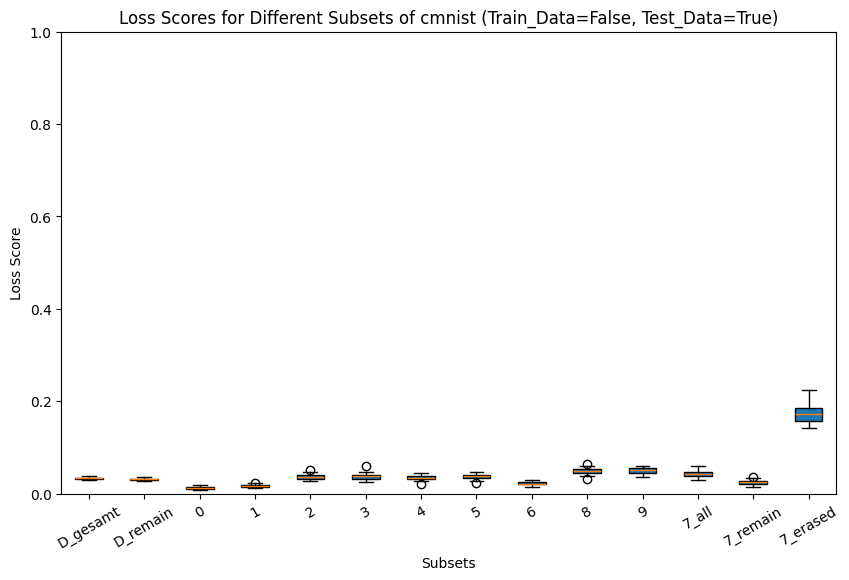

In [35]:
losses["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0348 - Standard Deviation for D_gesamt: 0.0022


Average Loss for D_remain: 0.0315 - Standard Deviation for D_remain: 0.0021


Average Loss for 0: 0.0165 - Standard Deviation for 0: 0.0026


Average Loss for 1: 0.0224 - Standard Deviation for 1: 0.0031


Average Loss for 2: 0.0348 - Standard Deviation for 2: 0.0060


Average Loss for 3: 0.0426 - Standard Deviation for 3: 0.0064


Average Loss for 4: 0.0292 - Standard Deviation for 4: 0.0037


Average Loss for 5: 0.0323 - Standard Deviation for 5: 0.0055


Average Loss for 6: 0.0204 - Standard Deviation for 6: 0.0040


Average Loss for 8: 0.0448 - Standard Deviation for 8: 0.0071


Average Loss for 9: 0.0491 - Standard Deviation for 9: 0.0078


Average Loss for 7_all: 0.0564 - Standard Deviation for 7_all: 0.0072


Average Loss for 7_remain: 0.0251 - Standard Deviation for 7_remain: 0.0045


Average Loss for 7_erased: 0.2659 - Standard Deviation for 7_erased: 0.0330
plotting...


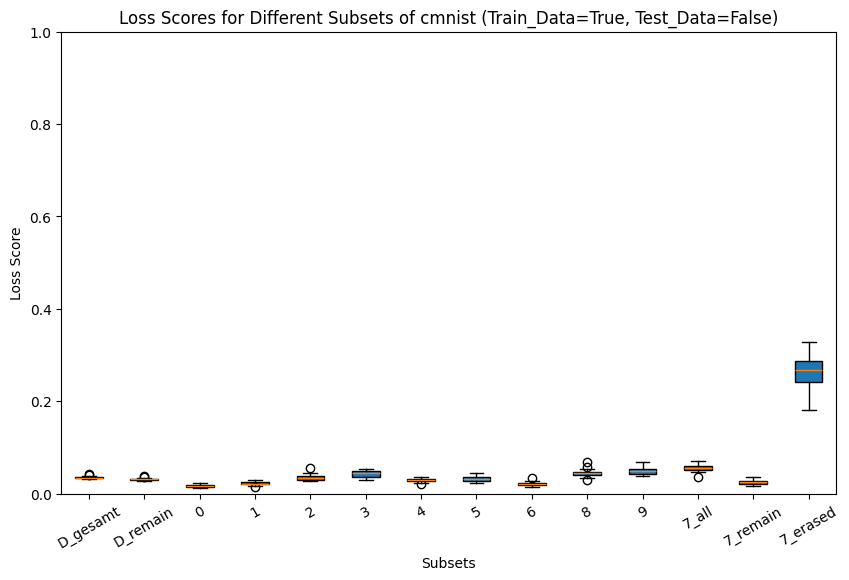

In [36]:
losses["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0358 - Standard Deviation for D_gesamt: 0.0023


Average Loss for D_remain: 0.0317 - Standard Deviation for D_remain: 0.0022


Average Loss for 0: 0.0134 - Standard Deviation for 0: 0.0021


Average Loss for 1: 0.0162 - Standard Deviation for 1: 0.0027


Average Loss for 2: 0.0349 - Standard Deviation for 2: 0.0068


Average Loss for 3: 0.0370 - Standard Deviation for 3: 0.0062


Average Loss for 4: 0.0358 - Standard Deviation for 4: 0.0044


Average Loss for 5: 0.0357 - Standard Deviation for 5: 0.0061


Average Loss for 6: 0.0240 - Standard Deviation for 6: 0.0049


Average Loss for 8: 0.0480 - Standard Deviation for 8: 0.0069


Average Loss for 9: 0.0484 - Standard Deviation for 9: 0.0073


Average Loss for 7_all: 0.0663 - Standard Deviation for 7_all: 0.0075


Average Loss for 7_remain: 0.0249 - Standard Deviation for 7_remain: 0.0040


Average Loss for 7_erased: 0.3568 - Standard Deviation for 7_erased: 0.0429
plotting...


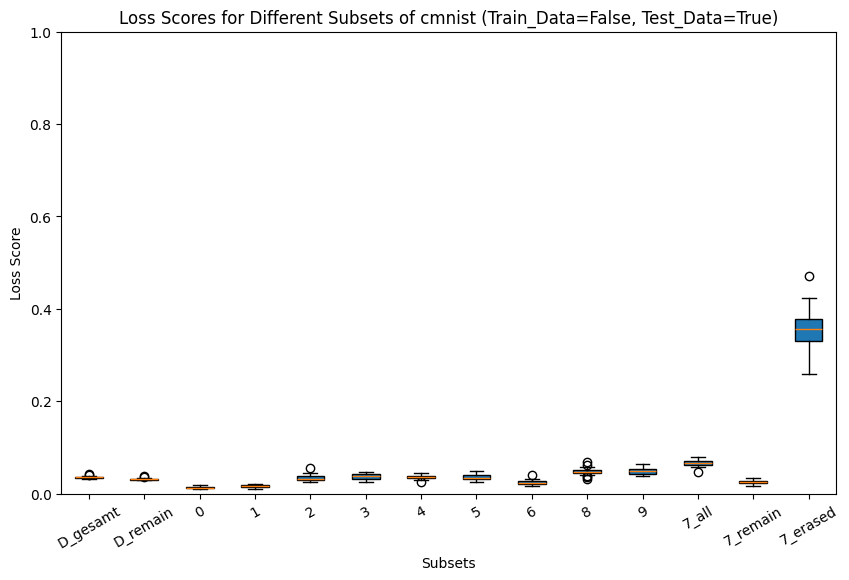

In [37]:
losses["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

___